In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


<br>
<br>

# 데이터 로드 / 전처리

In [2]:
# 데이터셋 디렉터리 경로
dataset_dir = './dataset/caltech101'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# 사진 크기
image_width = 100
image_height = 100

# ImageDataGenerator 초기화
# 0~1 사이로 숫자값 변경
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련셋 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')

# 검증셋 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')

# 테스트셋 제너레이터
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')


Found 1800 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


<br>
<br>

# 모델 생성

In [3]:
# VGG16 모델 생성
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(image_width, image_height, 3))

# 학습이 안되도록 설정
base_model.trainable = False

케라스에서 기본으로 제공하는 VGG16 모델을 사용하여 전이 학습을 하겠습니다. 'imagenet'으로 사전 훈련된 모델로, 완전연결 레이어인 최상층은 제외합니다. 특성 추출이기 때문에 베이스 모델은 학습이 안되게 합니다.

사전 훈련 모델에서 완전연결 아래층들은 이미지의 특징을 고차원적으로 파악하도록 미리 훈련되어 있습니다. 여기에 우리가 가진 데이터를 넣고 새로 학습을 합니다. 이렇게 하면 데이터가 적어도 더욱 빠르고 정확하게 학습이 가능합니다.
<br>
<br>
<br>

In [4]:
def build_model():
    
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])    
    
    return model

베이스 모델에 새로 Dense 레이어만 추가하였습니다.

<br>
<br>

# 훈련 및 평가

In [5]:
# 모델 생성
model = build_model()

# 훈련 시작
history = model.fit_generator(train_generator,
                              steps_per_epoch=60,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=20)


Epoch 1/10
60/60 [==============================] - 381s 6s/step - loss: 0.6240 - acc: 0.8294 - val_loss: 0.1169 - val_acc: 0.9600
Epoch 2/10
60/60 [==============================] - 379s 6s/step - loss: 0.1341 - acc: 0.9556 - val_loss: 0.1030 - val_acc: 0.9650
Epoch 3/10
60/60 [==============================] - 419s 7s/step - loss: 0.0841 - acc: 0.9756 - val_loss: 0.1779 - val_acc: 0.9550
Epoch 4/10
60/60 [==============================] - 411s 7s/step - loss: 0.0619 - acc: 0.9811 - val_loss: 0.0705 - val_acc: 0.9800
Epoch 5/10
60/60 [==============================] - 427s 7s/step - loss: 0.0295 - acc: 0.9906 - val_loss: 0.0865 - val_acc: 0.9767
Epoch 6/10
60/60 [==============================] - 408s 7s/step - loss: 0.0394 - acc: 0.9878 - val_loss: 0.1326 - val_acc: 0.9683
Epoch 7/10
60/60 [==============================] - 417s 7s/step - loss: 0.0146 - acc: 0.9944 - val_loss: 0.1169 - val_acc: 0.9650
Epoch 8/10
60/60 [==============================] - 412s 7s/step - loss: 0.0215 - a

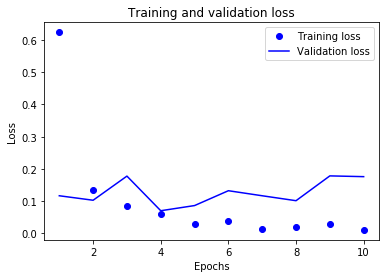

In [6]:
loss = history.history['loss']         # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')      # bo -> 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b -> 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


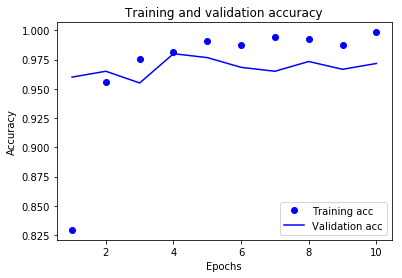

In [7]:
acc = history.history['acc']           # 훈련 정확도
val_acc = history.history['val_acc']   # 검증 정확도

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


검증 정확도가 최고 98% 나왔습니다. 데이터 증식을 하지 않았는데도 이전의 94% 보다 훨씬 성능이 향상되었습니다. 
<br>
<br>
<br>

In [8]:
# 모델 저장
model.save('./model/image_cnn_feature_extraction_model.h5')

<br>
<br>

# 테스트셋 확인

In [9]:
# 저장된 모델 파일 로드
model = models.load_model('./model/image_cnn_feature_extraction_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


모델의 trainable을 False로 변경하면 케라스와 텐서플로 버전에 따라 로드시 경고가 발생할 수 있습니다. 사용에는 문제가 없으니 안심하시기 바랍니다.
<br>
<br>
<br>

In [10]:
# 테스트셋 평가
results = model.evaluate_generator(test_generator)
results


[0.14283772013100132, 0.9683333188295364]

테스트셋의 정확도가 96% 입니다. 이전의 92% 보다 수치가 높아졌습니다. 데이터 증식까지 적용하면 아마도 정확도가 더 향상되지 않을까 생각됩니다.